# RNN model with gloVe embeddings

### inports

In [35]:
import sys
import numpy as np
import pickle
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Bidirectional, Embedding, LSTM, Dropout, Dense, Input

sys.path.append('../')
from utils import *


## Load the training input and dictionaries

In [2]:
X, y = load_training_input()
word_to_vector, words_to_index, index_to_words = load_dictionary()

MAX_TWEET_LENGTH = 30


## Split data

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)


### Create an embedding layer with gloVe vectors

In [8]:
vocab_size = len(words_to_index) + 1
emb_dim = word_to_vector[list(words_to_index.keys())[0]].shape[0]

emb_matrix = np.zeros((vocab_size, emb_dim))
for word, index in words_to_index.items():
    emb_matrix[index, :] = word_to_vector[word]

embedding_layer = Embedding(vocab_size, emb_dim, trainable=False)
embedding_layer.build((None,))
embedding_layer.set_weights([emb_matrix])


## Tweets Classifier Model

In [9]:
def tweetsModel():
    inputs = Input(MAX_TWEET_LENGTH, dtype=np.float32)
    embeddings = embedding_layer(inputs)

    X = Bidirectional(LSTM(64, return_sequences=True))(embeddings)
    X = Dropout(0.2)(X)

    X = Bidirectional(LSTM(64, return_sequences=True))(X)
    X = Dropout(0.2)(X)

    X = Bidirectional(LSTM(64, return_sequences=True))(embeddings)
    X = Dropout(0.2)(X)

    X = LSTM(64)(X)
    X = Dropout(0.2)(X)

    X = Dense(32, activation='relu')(X)
    X = Dense(1, activation='sigmoid')(X)

    model = tf.keras.Model(inputs=inputs, outputs=X)
    return model


In [10]:
model = tweetsModel()


In [11]:
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 50)            20000100  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 30, 128)           58880     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080  

### Compile

In [12]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.Adam(), 
              metrics=['accuracy'])
              

## Train

In [27]:
class myCallbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.99):
            print('99% training accuacy reached!')
            self.model.stop_training = True

callbacks = myCallbacks()

In [28]:
history = model.fit(X_train, y_train, 
                    batch_size=64, 
                    epochs=100,
                    callbacks=[callbacks])


Epoch 1/100
96/96 [==============================] - 28s 286ms/step - loss: 0.1225 - accuracy: 0.9517
Epoch 2/100
96/96 [==============================] - 28s 289ms/step - loss: 0.1067 - accuracy: 0.9562
Epoch 3/100
96/96 [==============================] - 29s 298ms/step - loss: 0.1240 - accuracy: 0.9511
Epoch 4/100
96/96 [==============================] - 28s 292ms/step - loss: 0.1192 - accuracy: 0.9524
Epoch 5/100
96/96 [==============================] - 27s 282ms/step - loss: 0.0918 - accuracy: 0.9652
Epoch 6/100
96/96 [==============================] - 26s 270ms/step - loss: 0.0871 - accuracy: 0.9658
Epoch 7/100
96/96 [==============================] - 27s 281ms/step - loss: 0.0844 - accuracy: 0.9665
Epoch 8/100
96/96 [==============================] - 33s 339ms/step - loss: 0.1219 - accuracy: 0.9484
Epoch 9/100
96/96 [==============================] - 37s 382ms/step - loss: 0.0952 - accuracy: 0.9635
Epoch 10/100
96/96 [==============================] - 31s 325ms/step - loss: 0.079

## Evaluate on the test set

In [29]:
model.evaluate(X_test, y_test)

48/48 [==============================] - 3s 67ms/step - loss: 1.7461 - accuracy: 0.7269


[1.7460720539093018, 0.7268549203872681]

## Plot the learning curves

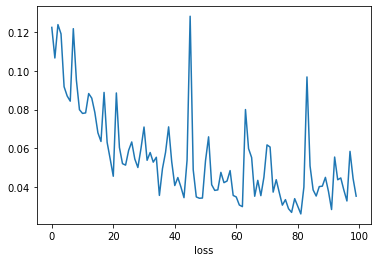

In [48]:
plt.xlabel('epochs')
plt.xlabel('loss')
plt.plot(history.history['loss'])

## Save the model

In [50]:
model.save('../models/model1.h5')

## Load the model and train

In [ ]:
model = tf.keras.models.load_model('../models/model1.h5')

In [ ]:
history = model.fit(X_train, y_train, 
                    batch_size=64, 
                    epochs=6)